## Start spark session

In [1]:
#pyspark session
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master("local[*]")\
    .appName("PayPayChallenge")\
    .getOrCreate()

## Load python libaries

In [2]:
#libraries
from pyspark.sql.types import StructField, StructType , LongType, StringType, DateType, DoubleType, IntegerType, TimestampType
from pyspark.sql import functions as F
from pyspark.sql.window import Window as W
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import StrMethodFormatter

## Set parameters and options

In [3]:
#parameters
log_file = './data/2015_07_22_mktplace_shop_web_log_sample.log'

pd.set_option('display.max_rows', None)  
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [4]:
#schema based on AWS Elastic Load Balancer
schema = StructType([
    StructField("timestamp", TimestampType()),
    StructField("elb", StringType()),
    StructField("client_port", StringType()),
    StructField("backend_port", StringType()),
    StructField("request_processing_time", DoubleType()),
    StructField("backend_processing_time", DoubleType()),
    StructField("response_processing_time", DoubleType()),
    StructField("elb_status_code", StringType()),
    StructField("backend_status_code", StringType()),
    StructField("received_bytes", IntegerType()),
    StructField("sent_bytes", IntegerType()),
    StructField("request", StringType()),
    StructField("user_agent", StringType()),
    StructField("ssl_cipher", StringType()),
    StructField("ssl_protocol", StringType())
])

In [5]:
#read log file
log_df = spark.read.format('csv').load(log_file,sep=' ',schema=schema,encoding='UTF-8',header=False)

In [6]:
#inspect first rows
n=5
log_df.limit(n).toPandas().head(n)

,timestamp,elb,client_port,backend_port,request_processing_time,backend_processing_time,response_processing_time,elb_status_code,backend_status_code,received_bytes,sent_bytes,request,user_agent,ssl_cipher,ssl_protocol
0,2015-07-22 05:00:47.143,marketpalce-shop,123.242.248.130:54635,10.0.6.158:80,0.000022,0.026109,0.000020,200,200,0,699,GET https://paytm.com:443/shop/authresponse?code=f2405b05-e2ee-4b0d-8f6a-9fed0fcfe2e0&state=null HTTP/1.1,"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.130 Safari/537.36",ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2
1,2015-07-22 05:15:21.580,marketpalce-shop,203.91.211.44:51402,10.0.4.150:80,0.000024,0.153340,0.000026,200,200,0,1497,GET https://paytm.com:443/shop/wallet/txnhistory?page_size=10&page_number=0&channel=web&version=2 HTTP/1.1,Mozilla/5.0 (Windows NT 6.1; rv:39.0) Gecko/20100101 Firefox/39.0,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2
2,2015-07-22 05:15:12.745,marketpalce-shop,1.39.32.179:56419,10.0.4.244:80,0.000024,0.164958,0.000017,200,200,0,157,GET https://paytm.com:443/shop/wallet/txnhistory?page_size=10&page_number=0&channel=web&version=2 HTTP/1.1,"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/43.0.2357.134 Safari/537.36",ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2
3,2015-07-22 05:01:16.369,marketpalce-shop,180.179.213.94:48725,10.0.6.108:80,0.000020,0.002333,0.000021,200,200,0,35734,GET https://paytm.com:443/shop/p/micromax-yu-yureka-moonstone-grey-MOBMICROMAX-YU-DUMM141CD60AF7C_34315 HTTP/1.0,-,ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2
4,2015-07-22 05:01:04.251,marketpalce-shop,120.59.192.208:13527,10.0.4.217:80,0.000024,0.015091,0.000016,200,200,68,640,POST https://paytm.com:443/papi/v1/expresscart/verify HTTP/1.1,"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.89 Safari/537.36",ECDHE-RSA-AES128-GCM-SHA256,TLSv1.2


In [7]:
#check the data's quality
log_df.describe().toPandas()

,summary,elb,client_port,backend_port,request_processing_time,backend_processing_time,response_processing_time,elb_status_code,backend_status_code,received_bytes,sent_bytes,request,user_agent,ssl_cipher,ssl_protocol
0,count,1158500,1158500,1158500,1158500,1158500,1158500,1158500,1158500,1158500,1158500,1158500,1158495,1158500,1158500
1,mean,None,None,None,-1.1705134829518615E-4,0.03305756986361663,-1.1899541907637441E-4,216.7690315062581,216.69855416486837,27.532892533448425,5488.19137850669,None,None,None,None
2,stddev,None,None,None,0.011824675161465738,0.36602516685578956,0.011824654382179903,42.31295192169145,42.25417090646583,204.49287327553898,15629.351806091025,None,None,None,None
3,min,marketpalce-shop,1.186.101.79:50613,-,-1.0,-1.0,-1.0,200,0,0,0,"""GET http://paytm.com:80/%27""()&%251%3CScRiPt%20%3Eprompt(909775)%3C/ScRiPt%3E/meru",\tMozilla/5.0 (Windows NT 6.1; rv:24.0) Gecko/20100101 Firefox/24.0,-,-
4,max,marketpalce-shop,99.8.170.3:60015,10.0.6.99:81,1.51E-4,58.698117,0.001433,504,504,23403,1068957,PUT https://paytm.com:443/shop/user/address HTTP/1.1,"ultrafone 105+(Linux; U;) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.0.3 Mobile Safari/534.30",Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0),TLSv1.2


## There seems to be entries with negative processing time, is it this valid to have these?

In [29]:
check_negative = log_df.where(F.col("request_processing_time")<=0)

In [31]:
n = 5
check_negative.limit(n).toPandas().head(n)

,timestamp,elb,client_port,backend_port,request_processing_time,backend_processing_time,response_processing_time,elb_status_code,backend_status_code,received_bytes,sent_bytes,request,user_agent,ssl_cipher,ssl_protocol
0,2015-07-22 05:15:25.581,marketpalce-shop,106.66.99.116:37913,-,-1.0,-1.0,-1.0,504,0,0,0,GET https://paytm.com:443/shop/orderdetail/1116223940?channel=web&version=2 HTTP/1.1,"Mozilla/5.0 (Windows NT 6.1) AppleWebKit/535.1 (KHTML, like Gecko) Chrome/14.0.794.0 Safari/535.1",ECDHE-RSA-AES128-SHA,TLSv1
1,2015-07-22 05:14:55.459,marketpalce-shop,70.39.187.170:43625,-,-1.0,-1.0,-1.0,504,0,0,0,GET https://paytm.com:443/offer/wp-content/plugins/contact-form-7/includes/js/jquery.form.min.js?ver=3.51.0-2014.06.20 HTTP/1.1,UCWEB/2.0 (Java; U; MIDP-2.0; Nokia203/20.37) U2/1.0.0 UCBrowser/8.7.0.218 U2/1.0.0 Mobile,ECDHE-RSA-AES128-SHA,TLSv1
2,2015-07-22 05:16:03.465,marketpalce-shop,144.36.185.50:50762,-,-1.0,-1.0,-1.0,504,0,0,0,POST https://paytm.com:443/shop/log HTTP/1.1,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; WOW64; Trident/5.0; gdn/adcp),ECDHE-RSA-AES128-SHA,TLSv1
3,2015-07-22 06:48:08.307,marketpalce-shop,15.211.153.75:5014,-,-1.0,-1.0,-1.0,504,0,0,0,POST https://paytm.com:443/shop/log HTTP/1.1,Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0),ECDHE-RSA-AES128-SHA256,TLSv1.2
4,2015-07-22 06:53:59.302,marketpalce-shop,119.235.53.134:53019,-,-1.0,-1.0,-1.0,504,0,0,0,POST https://paytm.com:443/shop/log HTTP/1.1,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0),ECDHE-RSA-AES128-SHA256,TLSv1.2


## Based from the https://docs.aws.amazon.com/elasticloadbalancing/latest/classic/ts-elb-error-message.html error code, these are requests that experienced timed out due to technical reasons from here, i remove entries with negative processing time and then parse through the client_port to get the ip addresses and requests to get the url that users visited.

In [8]:
#filter columns with what we need and remove request_processing_time, backend_processing_time and response_processing_time = -1.0
subset_log_df = log_df\
.filter((F.col("request_processing_time")>0.0) | (F.col("backend_processing_time")>0.0) | (F.col("response_processing_time")>0.0))\
.select('timestamp',F.split(log_df.client_port, ':').getItem(0).alias('ip_address'),F.split(log_df.request, ' ').getItem(1).alias('request'))

# 1.) Sessionalized the data
## Now based on the processed data, i sessionalize the weblogs. i first lag the timestamps by ip_address, compute their time difference and set an inactivity threshold of 15 minutes as reccomended.

In [72]:
#sessionize weblogs
user_session_id = subset_log_df.withColumn("last_event", F.lag('timestamp').over(W.partitionBy('ip_address').orderBy('timestamp')))\
.withColumn('lag_in_minutes', (F.unix_timestamp('timestamp') - F.unix_timestamp('last_event'))/60)\
.withColumn('is_new_session', F.when( F.col('lag_in_minutes') > 15 , 1).otherwise(0))\
.withColumn("user_session_id", F.sum('is_new_session').over(W.partitionBy('ip_address').orderBy('timestamp')))

In [21]:
n = 10
user_session_id.limit(n).toPandas().head(n)

,timestamp,ip_address,request,last_event,lag_in_minutes,is_new_session,user_session_id
0,2015-07-22 12:19:44.131,1.186.143.37,https://paytm.com:443/,NaT,NaN,0,0
1,2015-07-22 12:28:50.873,1.186.143.37,https://paytm.com:443/shop/cart?channel=web&version=2,2015-07-22 12:19:44.131,9.100000,0,0
2,2015-07-21 22:45:34.268,1.187.164.29,https://paytm.com:443/shop/authresponse?code=d1aa3c22-b32b-41a4-95c8-14097487c261,NaT,NaN,0,0
3,2015-07-21 22:45:44.871,1.187.164.29,https://paytm.com:443/shop/v1/frequentorders?channel=web&version=2,2015-07-21 22:45:34.268,0.166667,0,0
4,2015-07-21 22:45:46.201,1.187.164.29,https://paytm.com:443/shop?utm_source=Affiliates&utm_medium=VCOMM&utm_campaign=VCOMM&utm_term=24890,2015-07-21 22:45:44.871,0.033333,0,0
5,2015-07-21 22:48:37.646,1.187.164.29,https://paytm.com:443/shop/wallet/txnhistory?page_size=10&page_number=0&channel=web&version=2,2015-07-21 22:45:46.201,2.850000,0,0
6,2015-07-21 22:48:45.266,1.187.164.29,https://paytm.com:443/shop/wallet/getP2BModelWindowDetails,2015-07-21 22:48:37.646,0.133333,0,0
7,2015-07-21 22:49:18.011,1.187.164.29,https://paytm.com:443/shop/wallet/balance?channel=web&version=2,2015-07-21 22:48:45.266,0.550000,0,0
8,2015-07-21 22:55:12.225,1.187.164.29,https://paytm.com:443/shop/login?isIframe=true&theme=mp-web,2015-07-21 22:49:18.011,5.900000,0,0
9,2015-07-21 22:55:57.304,1.187.164.29,https://paytm.com:443/shop/cart?channel=web&version=2,2015-07-21 22:55:12.225,0.750000,0,0


# 2.)Determine the average session time
## Given that i'm able to establish user sessions, i can now calculate for session duration which i can derive the average session time from the logs.
## I simply get the min and max timestamp, corresponding to the start time of the session and end time of the session then i get the average.

In [22]:
min_max_timestamp_session = user_session_id\
.select('timestamp','ip_address','user_session_id')\
.withColumn("session_start", F.min('timestamp').over(W.partitionBy('ip_address','user_session_id')))\
.withColumn("session_end", F.max('timestamp').over(W.partitionBy('ip_address','user_session_id')))\
.drop('timestamp')\
.withColumn('session_duration', (F.unix_timestamp('session_end') - F.unix_timestamp('session_start'))/60)\
.distinct()

In [23]:
n = 5
min_max_timestamp_session.limit(n).toPandas().head(n)

,ip_address,user_session_id,session_start,session_end,session_duration
0,1.186.143.37,0,2015-07-22 12:19:44.131,2015-07-22 12:28:50.873,9.100000
1,1.187.164.29,0,2015-07-21 22:45:34.268,2015-07-21 23:00:56.557,15.366667
2,1.22.41.76,0,2015-07-22 12:43:13.170,2015-07-22 12:57:37.037,14.400000
3,1.23.208.26,0,2015-07-22 13:45:06.903,2015-07-22 14:02:23.589,17.283333
4,1.23.36.184,0,2015-07-22 01:18:25.288,2015-07-22 01:27:51.342,9.433333


## based on this we get that a session lasts at 9.58 minutes or roughly 10 minutes at an average, might be interesting to check the distribution in-case there might be outliers, events or specifics users pulling the average's center of tendency.

In [24]:
min_max_timestamp_session.agg(F.avg(F.col("session_duration"))).show()

+---------------------+
|avg(session_duration)|
+---------------------+
|    9.576064242863021|
+---------------------+



# 3.) Determine unique URL visits per session. To clarify, count a hit to a unique URL only once per session.
## here i simply apply a windowing function over ip address and user session and perform a distinct count of "requests" or urls

In [25]:
unique_url_visits_count = user_session_id\
.select('ip_address','user_session_id','request')\
.withColumn("unique_url_count", F.approx_count_distinct("request").over(W.partitionBy('ip_address','user_session_id')))\
.drop('request')\
.distinct()

In [26]:
n = 10
unique_url_visits_count.distinct().limit(n).toPandas().head(n)

,ip_address,user_session_id,unique_url_count
0,1.186.143.37,0,2
1,1.187.164.29,0,8
2,1.22.41.76,0,5
3,1.23.208.26,0,6
4,1.23.36.184,0,4
5,1.38.19.8,0,1
6,1.38.20.34,0,13
7,1.39.13.13,0,2
8,1.39.32.249,0,4
9,1.39.32.249,1,2


# 4.) Find the most engaged users, ie the IPs with the longest session times
## To find this, i can simply build up from the dataframe i created to solve for average duration time. I perform a sort of session duration to find the IPs with longest session times

In [27]:
longest_sessions = min_max_timestamp_session.sort(F.desc("session_duration"))

In [28]:
n=10
longest_sessions.limit(n).toPandas().head(n)

,ip_address,user_session_id,session_start,session_end,session_duration
0,220.226.206.7,7,2015-07-22 11:51:35.460,2015-07-22 12:59:52.958,68.283333
1,52.74.219.71,5,2015-07-22 12:10:36.665,2015-07-22 13:01:18.137,50.700000
2,119.81.61.166,5,2015-07-22 12:10:41.688,2015-07-22 13:01:20.176,50.650000
3,52.74.219.71,4,2015-07-22 06:30:43.792,2015-07-22 07:21:13.228,50.500000
4,54.251.151.39,4,2015-07-22 06:30:55.377,2015-07-22 07:21:24.343,50.483333
5,103.29.159.186,1,2015-07-22 06:30:52.217,2015-07-22 07:21:16.247,50.400000
6,119.81.61.166,4,2015-07-22 06:30:52.290,2015-07-22 07:21:14.178,50.366667
7,123.63.241.40,2,2015-07-22 06:30:59.944,2015-07-22 07:21:08.954,50.150000
8,202.134.59.72,2,2015-07-22 06:30:46.444,2015-07-22 07:20:54.655,50.133333
9,103.29.159.138,0,2015-07-22 06:30:57.519,2015-07-22 07:21:04.526,50.116667


# BONUS

## is 15 minutes a reasonable threshold? / What's a good threshold for session idle?
#### crude yet quick and simple way, get the average duration between a timestamp entry

In [44]:
user_session_id.agg(F.avg(F.col("lag_in_minutes"))).show()

+-------------------+
|avg(lag_in_minutes)|
+-------------------+
|  4.380572545332297|
+-------------------+



#### This tells us 4 minutes is candidate threshold, however averages can be pulled by it's distribution as shown below

Text(0.5, 1.0, 'Histrogram of the timestamp entry interval')

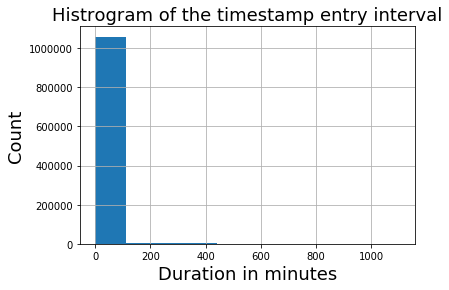

In [49]:
#create histogram to check distribution of activity intervals
hist_act_interval = user_session_id.select('lag_in_minutes').toPandas().dropna()
hist_act_interval.hist(bins=10)
plt.xlabel("Duration in minutes",fontsize=18)
plt.ylabel("Count",fontsize=18)
plt.title("Histrogram of the timestamp entry interval",fontsize=18)

## one way to figure out is find a certain point where the distrbution starts to taper-off, in this case, figuring the percentile where outliers start to show up and simply use that as the threshold

In [51]:
centiles = np.arange(0, 1.1, 0.10)
hist_act_interval.lag_in_minutes.quantile(centiles)

0.0    0.000000   
0.1    0.000000   
0.2    0.033333   
0.3    0.066667   
0.4    0.150000   
0.5    0.266667   
0.6    0.466667   
0.7    0.833333   
0.8    1.533333   
0.9    3.200000   
1.0    1103.616667
Name: lag_in_minutes, dtype: float64

According to this, somewhere at 90th percentile, the timestamp interval started to drastically change

Text(0.5, 1.0, 'Percentile distribution of timestamp interval')

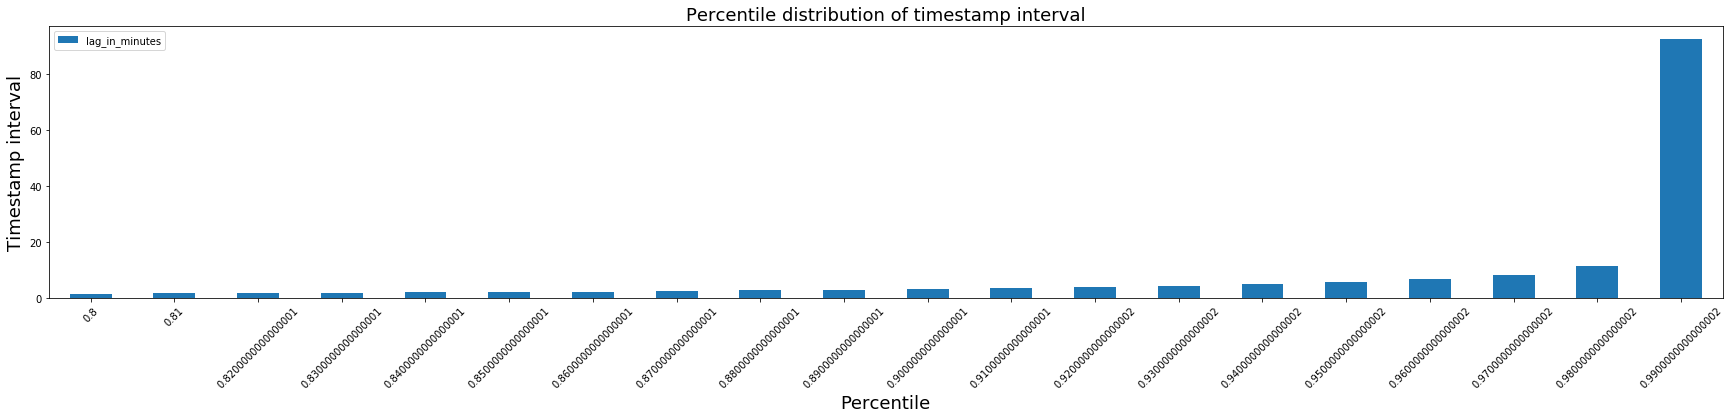

In [76]:
centiles = np.arange(0.8, 1, 0.01)
fig, ax = plt.subplots()
quartiles_ = pd.DataFrame(hist_act_interval.lag_in_minutes.quantile(centiles)).plot(kind='bar',figsize=(30,5),rot=45, ax=ax)
#ax.xticks(fontsize=14)
ax.set_xlabel("Percentile",fontsize=18)
ax.set_ylabel("Timestamp interval",fontsize=18)
plt.title("Percentile distribution of timestamp interval",fontsize=18)

#### There are a number of candidate points which we can select a point of change and it might be overly overfitting per say to consider more significant figures. We can select 98th percentile as our threshold to give more flexibility

In [59]:
hist_act_interval.lag_in_minutes.quantile([0.98])

0.98    11.516667
Name: lag_in_minutes, dtype: float64

### what we're given is 11.51 minutes or 12 minutes roughly, relatively near to 15 minutes. If we chose 12 minutes how much can this change our results?

In [66]:
#sessionize weblogs with 12 minutes as the threshold
user_session_id_12 = subset_log_df.withColumn("last_event", F.lag('timestamp').over(W.partitionBy('ip_address').orderBy('timestamp')))\
.withColumn('lag_in_minutes', (F.unix_timestamp('timestamp') - F.unix_timestamp('last_event'))/60)\
.withColumn('is_new_session', F.when( F.col('lag_in_minutes') > 11.516667, 1).otherwise(0))\
.withColumn("user_session_id", F.sum('is_new_session').over(W.partitionBy('ip_address').orderBy('timestamp')))

In [67]:
min_max_timestamp_session_12 = user_session_id_12\
.select('timestamp','ip_address','user_session_id')\
.withColumn("session_start", F.min('timestamp').over(W.partitionBy('ip_address','user_session_id')))\
.withColumn("session_end", F.max('timestamp').over(W.partitionBy('ip_address','user_session_id')))\
.drop('timestamp')\
.withColumn('session_duration', (F.unix_timestamp('session_end') - F.unix_timestamp('session_start'))/60)\
.distinct()

In [68]:
min_max_timestamp_session_12.agg(F.avg(F.col("session_duration"))).show()

+---------------------+
|avg(session_duration)|
+---------------------+
|    8.739286246261274|
+---------------------+



In [70]:
# average session time of 15 minutes - average session time of roughly 12 minutes
9.576064242863021 - 8.739286246261274

0.8367779966017466

Hardly a difference in average session duration, depending on the usecase of this metric. How about the count of sessions?

In [73]:
user_session_id.select('ip_address','user_session_id').distinct().count()

107737

In [74]:
user_session_id_12.select('ip_address','user_session_id').distinct().count()

111892

In [75]:
111892-107737

4155

By changing the threshold to roughly 12 minutes, the count of sessions increased by 4155. This can greatly affect other metrics reliant on the count of sessions. But in any case, depending on use case. 15 Minutes could suffice or using 11.52 minutes could be desirable. What matters is which accurately reflects on the user's behaviour. Given that i'm working with a single day's log, this 'sample' average will naturally be different from the population average given idosyncracies of traffic behavior in a particular day as compared to the population of web traffic for paytm.

## Extension of 4; Which IPs have the longest AVERAGE session duration?
This is not necesarily a better answer as averaging can remove a lot of information in data (i.e. a user can simply be just checking out his/her items stored in the carts vs actually browsing for items to add to cart then check them out) which are event driven and can be useful for a marketing use-case (i.e. promotions, a/b testing and etc...) but in some cases, it could important for things like capacity planning or similar activities for server load and as such.

In [39]:
avg_sessions_per_ip = min_max_timestamp_session.withColumn("average_sessions", F.avg("session_duration").over(W.partitionBy('ip_address')))\
.drop('session_start','session_end','user_session_id','session_duration').distinct()

In [40]:
n=10
avg_sessions_per_ip.limit(n).toPandas().head(n)

,ip_address,average_sessions
0,1.186.143.37,9.100000
1,1.187.164.29,15.366667
2,1.22.41.76,14.400000
3,1.23.208.26,17.283333
4,1.23.36.184,9.433333
5,1.38.19.8,10.983333
6,1.38.20.34,16.983333
7,1.39.13.13,1.750000
8,1.39.32.249,5.808333
9,1.39.32.59,0.000000


In [41]:
#after sorting
n=10
avg_sessions_per_ip.sort(F.desc("average_sessions")).limit(n).toPandas().head(n)

,ip_address,average_sessions
0,103.29.159.138,50.116667
1,115.184.198.199,50.050000
2,122.169.141.4,50.033333
3,122.172.183.180,49.850000
4,14.99.226.79,49.466667
5,107.167.108.146,49.350000
6,117.217.94.18,49.283333
7,117.220.188.232,49.200000
8,59.176.75.122,48.866667
9,1.22.213.213,48.750000
